<a href="https://colab.research.google.com/github/ennur/Malicious-URL-Detection/blob/main/malicious_URL_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv(".../urldata.csv")

df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df.head()

index_names = df[ df['label'].isnull() ].index 
df.drop(index_names,axis=0,inplace=True)
df.tail

<bound method NDFrame.tail of                                                       url      label  result
0                                  https://www.google.com     benign       0
1                                 https://www.youtube.com     benign       0
2                                https://www.facebook.com     benign       0
3                                   https://www.baidu.com     benign       0
4                               https://www.wikipedia.org     benign       0
...                                                   ...        ...     ...
450171        http://ecct-it.com/docmmmnn/aptgd/index.php  malicious       1
450172  http://faboleena.com/js/infortis/jquery/plugin...  malicious       1
450173  http://faboleena.com/js/infortis/jquery/plugin...  malicious       1
450174                             http://atualizapj.com/  malicious       1
450175  http://writeassociate.com/test/Portal/inicio/I...  malicious       1

[450176 rows x 3 columns]>

In [2]:
#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df.head(n=20)

,url,label,result
0,http://scredlble.com/login/GDrive/1ff71c3539f0...,malicious,1
1,https://www.skydive.tv/,benign,0
2,https://www.worshipbanners.org/david_stanfield...,benign,0
3,http://95.213.186.93/information.cgi,malicious,1
4,http://ashooooor-001-site1.ftempurl.com/b7aba,malicious,1
5,https://www.umontreal.ca/english/overview/over...,benign,0
6,https://www.ca.linkedin.com/directory/people/c...,benign,0
7,https://www.selau642.wordpress.com/2008/06/17/...,benign,0
8,https://www.maxgalleries.com/store/store-stars...,benign,0
9,https://www.en.wikipedia.org/wiki/Category:Can...,benign,0


In [3]:
from urllib.parse import urlparse
X,y = df['url'],df['result']
X.head()

0    http://scredlble.com/login/GDrive/1ff71c3539f0...
1                              https://www.skydive.tv/
2    https://www.worshipbanners.org/david_stanfield...
3                 http://95.213.186.93/information.cgi
4        http://ashooooor-001-site1.ftempurl.com/b7aba
Name: url, dtype: object

In [4]:
y.value_counts(normalize=True)

0    0.768006
1    0.231994
Name: result, dtype: float64

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import re # for regex

def custom_tokenizer(string):
  final = []
  tokens = [a for a in list(urlparse(string)) if a]
  for t in tokens:
    final.extend(re.compile("[.-]").split(t))
  return final

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

vect = CountVectorizer(tokenizer=custom_tokenizer)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,f1_score,auc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
X_train.shape, X_val.shape, X_test.shape


((270105,), (90035,), (90036,))

In [10]:
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from joblib import dump,load

In [11]:
random_grid = {'model__n_estimators': [10,20,30,40,50],
               'model__min_samples_split':[1,2,3,4],
               'model__min_samples_leaf':[1,2,3,4]}

model = RandomForestClassifier()
tree_pipe = Pipeline([('vect', vect), ('model', model)])

rf_random = RandomizedSearchCV(tree_pipe, random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 48.5min finished


['finalized_model.sav']

In [12]:
filename = 'finalized_model.sav'
dump(rf_random.best_estimator_, filename)

train_proba = rf_random.best_estimator_.predict_proba(X_val)
train_proba = train_proba[:, 1]

yhat = rf_random.best_estimator_.predict(X_val)
lr_precision, lr_recall, _ = precision_recall_curve(y_val, train_proba)
lr_f1, lr_auc = f1_score(y_val, yhat), auc(lr_recall, lr_precision)

print(" f1_score : {}" .format(lr_f1))
print(" auc : {}" .format(lr_auc))


 f1_score : 0.9959610926558803
 auc : 0.9992570216703469


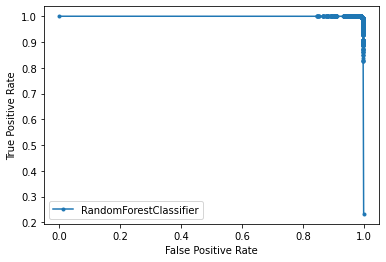

In [13]:
pyplot.plot(lr_recall, lr_precision, marker='.', label='RandomForestClassifier')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [17]:
def confusion_matrix_visualization(con_mat):

  group_names = ["True_Neg","False_Pos","False_Neg","True_Pos"]
  group_counts= ["{0:0.0f}".format(value) for value in
                con_mat.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                     con_mat.flatten()/np.sum(con_mat)]

  labels = [f"{v1}\n{v2}\n{v3}"for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2) 
  return labels

In [48]:
def false_positive_rate(conf_mat):
  return ((conf_mat[1][0] / float(sum(conf_mat[1])))*100)

def false_negative_rate(conf_matrix):
  return ( (conf_matrix[0][1] / float(sum(conf_matrix[0]))*100))

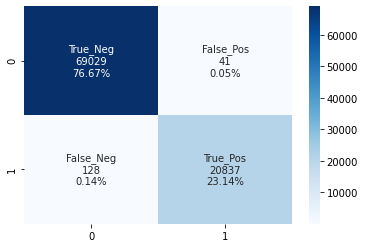

In [21]:
cm_val=confusion_matrix(y_val, train_proba.round())
sns.heatmap(cm_val, annot=confusion_matrix_visualization(cm_val), fmt='', cmap='Blues')

In [23]:
#Precision = TruePositive / (TruePositive + FalsePositive)
precision= cm_val[0,0] / (cm_val[0,0]+cm_val[1,0])

#Recall = TruePositive / (TruePositive + FalseNegative)
#tp rate
#Sensitivity 
recall=cm_val[0,0] /(cm_val[0,0]+cm_val[0,1])

print(" precision : {}" .format(precision))
print(' recall : {}' .format(recall))


 precision : 0.9981491389158003
 recall : 0.9994063993050528


In [51]:
print("False positive rate : %f %%" % false_positive_rate(cm_val))
print('False negative rate : %f %%' % false_negative_rate(cm_val))

False positive rate : 0.610541 %
False negative rate : 0.059360 %


In [25]:
test_proba = rf_random.best_estimator_.predict(X_test)

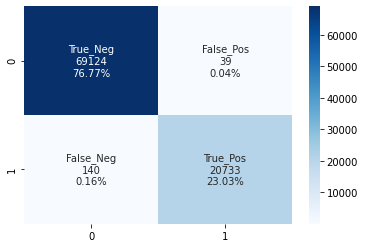

In [27]:
cm_test=confusion_matrix(y_test, test_proba)
sns.heatmap(cm_val, annot=confusion_matrix_visualization(cm_test), fmt='', cmap='Blues')

In [52]:
print("False positive rate : %f %%" % false_positive_rate(cm_test))
print('False negative rate : %f %%' % false_negative_rate(cm_test))

False positive rate : 0.670723 %
False negative rate : 0.056389 %


In [53]:
# predict one sample
loaded_pipe = load("finalized_model.sav")

In [60]:
result = loaded_pipe.predict(["https://www.kaggle.com/"])
result

array([0])